In [1]:
DATA_PATH = '../Data/Raw/raw_df_unique.csv'
PKL_EXPORT_PATH = "../data/processed/0_DataCleaned_df.pkl"
CSV_EXPORT_PATH = "../data/processed/0_DataCleaned_df.csv"
US_STATES_ABBR = '../Data/Raw/us_states.xlsx'

In [2]:
# Packages to import
import pandas as pd 
import numpy as np
import re
import logging
import pickle
import glob
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
raw_df = pd.read_csv(DATA_PATH).set_index('Unnamed: 0').reset_index(drop=True)
raw_df.shape

(1542, 12)

In [4]:
raw_df

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue
0,Data Engineer,Employer Provided Salary:$175K - $200K,At Expa we're dedicated to being the best plac...,3.7,Expa\n3.7,"Los Angeles, CA",1 to 50 Employees,2013,Company - Private,Business Consulting,Management & Consulting,Unknown / Non-Applicable
1,Data Scientist/Data Engineer - Economic Research,Employer Provided Salary:$121K - $151K,Why Glassdoor?\nOur mission is to help people ...,4.3,Glassdoor\n4.3,"Chicago, IL",501 to 1000 Employees,2007,Company - Private,Internet & Web Services,Information Technology,Unknown / Non-Applicable
2,Data Engineer,-1,Job Details\nDescription\nCivicPlus is a trust...,3.6,CivicPlus\n3.6,Remote,501 to 1000 Employees,1998,Company - Private,Computer Hardware Development,Information Technology,$25 to $100 million (USD)
3,Data Scientist,Employer Provided Salary:$60K - $140K,"We are looking for junior, mid-level or senior...",-1.0,Tech brothers infoservices,Remote,Unknown,-1,Company - Public,-1,-1,Unknown / Non-Applicable
4,Data Scientist,Employer Provided Salary:$79K - $117K,No Relocation Assistance Offered\n# 154742 - P...,4.2,Colgate-Palmolive\n4.2,"Piscataway, NJ",10000+ Employees,1806,Company - Public,Consumer Product Manufacturing,Manufacturing,$10+ billion (USD)
...,...,...,...,...,...,...,...,...,...,...,...,...
1537,Data Scientist I (Machine Learning),$102K - $140K (Glassdoor est.),Battelle delivers when others can’t. We conduc...,3.9,Battelle\n3.9,"Columbus, OH",1001 to 5000 Employees,1929,Nonprofit Organization,Research & Development,Management & Consulting,$5 to $10 billion (USD)
1538,Machine Learning Engineer,Employer Provided Salary:$167K,Job Description:\nSolve cutting edge Al proble...,3.9,"Zoom Video Communications, Inc.\n3.9","San Jose, CA",1001 to 5000 Employees,2011,Company - Public,Information Technology Support Services,Information Technology,$1 to $5 billion (USD)
1539,Sr. Machine Learning Engineer,Employer Provided Salary:$136K - $182K,Sr. Machine Learning Engineer\nJob ID\n1005393...,3.9,Disney\n3.9,"Burbank, CA",10000+ Employees,1923,Company - Public,Film Production,Media & Communication,$10+ billion (USD)
1540,Machine Learning Data Scientist - Growth Algor...,Employer Provided Salary:$181K - $262K,"We’re a team of bright, kind individuals who a...",3.2,Stitch Fix\n3.2,Remote,10000+ Employees,2011,Company - Public,Other Retail Stores,Retail & Wholesale,$1 to $5 billion (USD)


In [5]:
# Display random answer
raw_df.sample(1).iloc[0]

Job Title                                                Data Engineer
Salary Estimate                 Employer Provided Salary:$150K - $300K
Job Description      What we're looking for\nStytch is the platform...
Rating                                                             5.0
Company Name                                               Stytch\n5.0
Location                                                    California
Size                                                 1 to 50 Employees
Founded                                                           2020
Type of ownership                                     Company - Public
Industry                       Enterprise Software & Network Solutions
Sector                                          Information Technology
Revenue                                       Unknown / Non-Applicable
Name: 544, dtype: object

In [6]:
raw_df.sample()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue
1473,Senior Software Engineer - Machine Learning,$120K - $177K (Glassdoor est.),Responsible for implementing various algorithm...,4.9,Abacus.AI\n4.9,"San Francisco, CA",51 to 200 Employees,2019,Company - Private,Enterprise Software & Network Solutions,Information Technology,Unknown / Non-Applicable


In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1542 entries, 0 to 1541
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          1542 non-null   object 
 1   Salary Estimate    1542 non-null   object 
 2   Job Description    1542 non-null   object 
 3   Rating             1542 non-null   float64
 4   Company Name       1542 non-null   object 
 5   Location           1541 non-null   object 
 6   Size               1542 non-null   object 
 7   Founded            1542 non-null   int64  
 8   Type of ownership  1542 non-null   object 
 9   Industry           1542 non-null   object 
 10  Sector             1542 non-null   object 
 11  Revenue            1542 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 144.7+ KB


# Data Cleaning & preprocessing
__________________________________________________________________________________________________________________________________________________


## 2. Salary Column

### 1. Parse the Salary Data Column 
### 2. Remove rows in which salary equal -1
### 3. Remove any Text in the columns
### 4. Change Hourly Rate salary to Yearly rate
### 5. split salary into min and max salary column
### 6. calculate the avg salary

In [8]:
# How many Null values in the salary column
len(raw_df[raw_df['Salary Estimate' ] == '-1'])

299

In [9]:
# Remove Columns where Salary == -1, We Ended up with 1243 rows that have salary
raw_df = raw_df[raw_df['Salary Estimate'] != '-1']
len(raw_df)

1243

In [10]:
raw_df['Salary Estimate'].sample(20)

1088                         $68K - $94K (Glassdoor est.)
1297                        Employer Provided Salary:$85K
73                         $101K - $157K (Glassdoor est.)
1259                        $89K - $128K (Glassdoor est.)
331                          $53K - $83K (Glassdoor est.)
235                         $80K - $107K (Glassdoor est.)
252                  Employer Provided Salary:$65K - $95K
976                         Employer Provided Salary:$72K
1374               Employer Provided Salary:$164K - $262K
523                Employer Provided Salary:$107K - $179K
533     Employer Provided Salary:$60.00 - $65.00 Per Hour
1152                Employer Provided Salary:$77K - $116K
1141               Employer Provided Salary:$100K - $140K
431                Employer Provided Salary:$122K - $171K
697                Employer Provided Salary:$150K - $180K
114                Employer Provided Salary:$120K - $150K
128     Employer Provided Salary:$60.00 - $65.00 Per Hour
62            

In [11]:
raw_df = raw_df.copy()
# create a column for if it is per hour salries
raw_df['hourly'] = raw_df['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
# create a column if salaries are provided by the employer
raw_df['employer_provided'] = raw_df['Salary Estimate'].apply(lambda x: 1 if 'employer provided salary:' in x.lower() else 0)

In [12]:
raw_df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,hourly,employer_provided
0,Data Engineer,Employer Provided Salary:$175K - $200K,At Expa we're dedicated to being the best plac...,3.7,Expa\n3.7,"Los Angeles, CA",1 to 50 Employees,2013,Company - Private,Business Consulting,Management & Consulting,Unknown / Non-Applicable,0,1
1,Data Scientist/Data Engineer - Economic Research,Employer Provided Salary:$121K - $151K,Why Glassdoor?\nOur mission is to help people ...,4.3,Glassdoor\n4.3,"Chicago, IL",501 to 1000 Employees,2007,Company - Private,Internet & Web Services,Information Technology,Unknown / Non-Applicable,0,1
3,Data Scientist,Employer Provided Salary:$60K - $140K,"We are looking for junior, mid-level or senior...",-1.0,Tech brothers infoservices,Remote,Unknown,-1,Company - Public,-1,-1,Unknown / Non-Applicable,0,1
4,Data Scientist,Employer Provided Salary:$79K - $117K,No Relocation Assistance Offered\n# 154742 - P...,4.2,Colgate-Palmolive\n4.2,"Piscataway, NJ",10000+ Employees,1806,Company - Public,Consumer Product Manufacturing,Manufacturing,$10+ billion (USD),0,1
5,Sr. Business Data Analyst,Employer Provided Salary:$60.00 - $70.00 Per Hour,Business Analysis Skills\nGood Data analysis S...,4.6,CTI Consulting\n4.6,"Deerfield Beach, FL",1 to 50 Employees,-1,Company - Private,-1,-1,$1 to $5 million (USD),1,1


In [13]:
# Use Regex to Remove Text in the Salary Column
salary = raw_df['Salary Estimate'].str.replace(r'[^0-9-_]', '',regex = True)
salary.sample(10)

932         37-51
101     5000-5600
1417       95-134
1309      180-205
951         57-82
197     6000-6500
463        92-134
604         44-94
634       125-179
1256       70-105
Name: Salary Estimate, dtype: object

In [14]:
# there is a problem with the perhour salaries after removing the text
print(salary.loc[266])
print(salary.loc[869])
print(salary.loc[527])

5000-5500
5800-6000
7500


In [15]:
# split the salary column into a list 
list_salary =salary.str.split('-')

In [16]:
# We need to change the per hour salary to per year
# per year rate = no. * 1.8 / 100
#Loop through the salary list and check for hourly columns
j = 0
for s in list_salary:
    if raw_df.iloc[j,12] == 1:
        for i in range(len(s)):
            s[i] = (int(s[i]) * 1.8)/ 100
    j +=1

In [17]:
print(list_salary.loc[266])
print(list_salary.loc[869])
print(list_salary.loc[527])

[90.0, 99.0]
[104.4, 108.0]
[135.0]


In [18]:
# Create Two new columns( one for min_salary and one for max_salary)
raw_df['min_salary'] = list_salary.apply(lambda x: int(x[0]))
# Takes x[0] if list has only one value,
raw_df['max_salary'] = list_salary.apply(lambda x: int(x[1]) if len(x)>1 else int(x[0]))

In [19]:
list_salary

0           [175, 200]
1           [121, 151]
3            [60, 140]
4            [79, 117]
5       [108.0, 126.0]
             ...      
1537        [102, 140]
1538             [167]
1539        [136, 182]
1540        [181, 262]
1541         [97, 234]
Name: Salary Estimate, Length: 1243, dtype: object

In [20]:
# Create avg_salary Column
raw_df['avg_salary'] = (raw_df.min_salary + raw_df.max_salary) / 2

In [21]:
raw_df

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,hourly,employer_provided,min_salary,max_salary,avg_salary
0,Data Engineer,Employer Provided Salary:$175K - $200K,At Expa we're dedicated to being the best plac...,3.7,Expa\n3.7,"Los Angeles, CA",1 to 50 Employees,2013,Company - Private,Business Consulting,Management & Consulting,Unknown / Non-Applicable,0,1,175,200,187.5
1,Data Scientist/Data Engineer - Economic Research,Employer Provided Salary:$121K - $151K,Why Glassdoor?\nOur mission is to help people ...,4.3,Glassdoor\n4.3,"Chicago, IL",501 to 1000 Employees,2007,Company - Private,Internet & Web Services,Information Technology,Unknown / Non-Applicable,0,1,121,151,136.0
3,Data Scientist,Employer Provided Salary:$60K - $140K,"We are looking for junior, mid-level or senior...",-1.0,Tech brothers infoservices,Remote,Unknown,-1,Company - Public,-1,-1,Unknown / Non-Applicable,0,1,60,140,100.0
4,Data Scientist,Employer Provided Salary:$79K - $117K,No Relocation Assistance Offered\n# 154742 - P...,4.2,Colgate-Palmolive\n4.2,"Piscataway, NJ",10000+ Employees,1806,Company - Public,Consumer Product Manufacturing,Manufacturing,$10+ billion (USD),0,1,79,117,98.0
5,Sr. Business Data Analyst,Employer Provided Salary:$60.00 - $70.00 Per Hour,Business Analysis Skills\nGood Data analysis S...,4.6,CTI Consulting\n4.6,"Deerfield Beach, FL",1 to 50 Employees,-1,Company - Private,-1,-1,$1 to $5 million (USD),1,1,108,126,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537,Data Scientist I (Machine Learning),$102K - $140K (Glassdoor est.),Battelle delivers when others can’t. We conduc...,3.9,Battelle\n3.9,"Columbus, OH",1001 to 5000 Employees,1929,Nonprofit Organization,Research & Development,Management & Consulting,$5 to $10 billion (USD),0,0,102,140,121.0
1538,Machine Learning Engineer,Employer Provided Salary:$167K,Job Description:\nSolve cutting edge Al proble...,3.9,"Zoom Video Communications, Inc.\n3.9","San Jose, CA",1001 to 5000 Employees,2011,Company - Public,Information Technology Support Services,Information Technology,$1 to $5 billion (USD),0,1,167,167,167.0
1539,Sr. Machine Learning Engineer,Employer Provided Salary:$136K - $182K,Sr. Machine Learning Engineer\nJob ID\n1005393...,3.9,Disney\n3.9,"Burbank, CA",10000+ Employees,1923,Company - Public,Film Production,Media & Communication,$10+ billion (USD),0,1,136,182,159.0
1540,Machine Learning Data Scientist - Growth Algor...,Employer Provided Salary:$181K - $262K,"We’re a team of bright, kind individuals who a...",3.2,Stitch Fix\n3.2,Remote,10000+ Employees,2011,Company - Public,Other Retail Stores,Retail & Wholesale,$1 to $5 billion (USD),0,1,181,262,221.5


## 1. Job title Column

### 1. Try to classify the job titles in terms of title and seniority
### 2. the seniority column has alot of missing values

In [22]:
raw_df['Job Title'].value_counts().head(60)

Data Engineer                                            121
Data Analyst                                              93
Data Scientist                                            86
Machine Learning Engineer                                 43
Senior Data Engineer                                      23
Senior Machine Learning Engineer                          15
Senior Data Scientist                                     14
Sr. Data Engineer                                         11
Junior Data Engineer                                      11
Big Data Engineer                                         10
Business Analyst                                           8
Data Analytics Engineer                                    7
Data Engineer II                                           6
AWS Data Engineer                                          6
Entry Level Business Analyst                               6
Senior Data Analyst                                        5
Junior Data Analyst     

In [23]:
def title_simplifier(title):
    if 'data scientist' in title.lower() or 'data science' in title.lower() or 'decision scientist' in title.lower():
        return 'data scientist'
    elif 'data analyst' in title.lower() or 'analyst' in title.lower() :
        return 'data analyst'
    elif 'artificial intelligence' in title.lower() or 'machine learning' in title.lower() or 'nlp engineer' in title.lower():
        return 'machine learning engineer'
    elif 'deep learning' in title.lower() or 'ml' in title.lower() or 'ai' in title.lower() or 'intelligence' in title.lower():
        return 'machine learning engineer'
    elif 'data engineer' in title.lower():
        return 'data engineer'
    # elif 'quantitative researcher' in title.lower():
    #     return 'quantitative researcher'
    # elif 'data partnerships lead' in title.lower():
    #     return 'data partnerships lead'
    elif 'scientist' in title.lower():
        return 'data scientist'
    elif 'engineer' in title.lower():
        return'data engineer'
    elif 'analytics' in title.lower() or 'visualization' in title.lower():
        return 'data analyst'
    else:
        return 'na'
    
def seniorty(title):
    if 'senior' in title.lower() or 'sr' in title.lower() or 'lead' in title.lower() or 'principal' in title.lower():
        return 'senior'
    elif 'jr' in title.lower() or 'jr.' in title.lower() or 'junior' in title.lower():
        return 'junior'
    else:
        return 'na'

In [24]:
raw_df['job_title'] = raw_df['Job Title'].apply(title_simplifier)

In [25]:
raw_df.job_title.value_counts()

data engineer                356
data analyst                 329
data scientist               287
machine learning engineer    246
na                            25
Name: job_title, dtype: int64

In [26]:
raw_df.loc[raw_df['job_title'] == 'na','Job Title'].value_counts().head(60)

Remote Customer Service Representative                                            2
Quantitative Researcher                                                           2
SDE - Amazon Robotics, Robotic                                                    2
Data Specialist                                                                   2
Personalized Internet Assessor (US)                                               2
Software Support Representative                                                   2
Front End Developer                                                               1
Operations/HR Assistant                                                           1
Small Business Loan Collector                                                     1
DevSecOps                                                                         1
Quantitative Research                                                             1
Biological Science Assistant (Field and Data Assistant)                     

In [27]:
# remove unrelated jobs
raw_df = raw_df.loc[raw_df['job_title'] != 'na']

In [28]:
raw_df= raw_df.copy()
raw_df['seniority'] = raw_df['Job Title'].apply(seniorty)

In [29]:
# alot of Na in the seniority column
raw_df['seniority'].value_counts()

na        964
senior    205
junior     49
Name: seniority, dtype: int64

## 3. Description Column

### 1. Create a new column call Desc_length, contain no. of characters in each job description

In [30]:
raw_df['Job Description'][0]

"At Expa we're dedicated to being the best place for entrepreneurs to create and build companies. Expa was founded in 2013 by Uber co-founder Garrett Camp to help bring great ideas to life. We're builders, founders, and operators ourselves, know the struggles that come with starting a new company, and what it takes to succeed. We support entrepreneurs with more than just funding — we offer a valuable network, office space, and our advice and expertise. Expa Studio combines technical and design expertise, operational support, and capital to turn bold ideas into category-defining companies.\nYour role\nYou will be a Data Engineer (ML, AI) at a new studio company tasked with building or leveraging machine learning solutions and developing applications utilizing AI frameworks and methods. This position will require you to design and collaborate with members across the organization to deliver product innovations leveraging your unique knowledge and skill set in Machine Learning and Artifici

In [31]:
raw_df['desc_len'] = raw_df['Job Description'].apply(lambda x: len(x))
raw_df['desc_len']

0       3144
1       8120
3       1338
4       5372
5        828
        ... 
1537    6439
1538    3769
1539    2988
1540    7039
1541    8046
Name: desc_len, Length: 1218, dtype: int64

<Axes: >

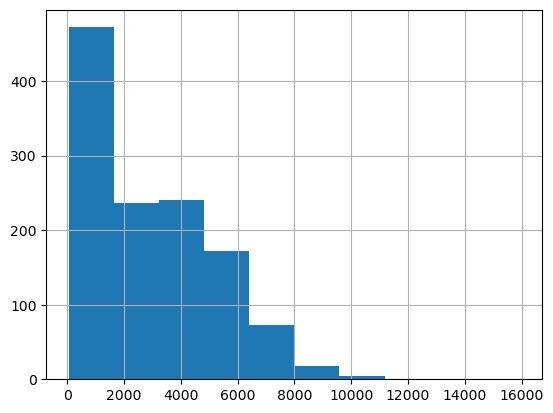

In [32]:
raw_df['desc_len'].hist()

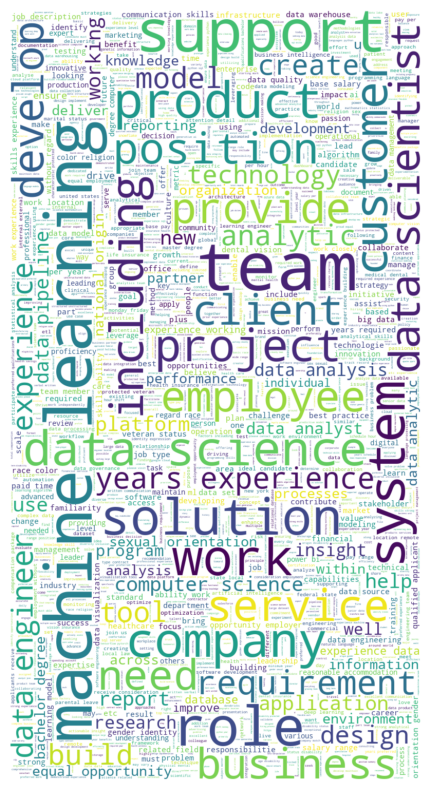

In [35]:
words = " ".join(raw_df['Job Description'])

def punctuation_stop(text):
    """remove punctuation and stop words"""
    filtered = []
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered


words_filtered = punctuation_stop(words)

text = " ".join([ele for ele in words_filtered])

wc= WordCloud(background_color="white", random_state=1,stopwords=STOPWORDS, max_words = 2000, width =800, height = 1500)
wc.generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show()

In [36]:
words_count= {}
for word in words_filtered:
    words_count[word] = words_count.get(word,0) +1
tools = ['python', 'r', 'aws','hadoop','spark','excel''statistics','sql', 'azure','tensorflow','pytorch','keras']
techs = ['nlp','llm','visualization','mining','cloud','ml','ai', 'deep','chatgpt','neural','etl','warehousing','insights','research']
education =['phd','doctorate','master','msc','bsc','bachelor']
for tool in education:
    if tool in words_count:
        print(f'{tool} : {words_count[tool]}')

phd : 68
doctorate : 6
master : 191
msc : 1
bsc : 3
bachelor : 393


In [37]:
# make a column to count how many tools used in every job
count = []
for row in range(len(raw_df)):
    sum = 0
    for tool in tools:
        if tool in raw_df.iloc[row,2].lower():
            sum +=1
    count.append(sum)
raw_df['tools'] = count

In [41]:
# make a column to count no. of technologies in every job
count = []
for row in range(len(raw_df)):
    sum = 0
    for tech in techs:
        if tech in raw_df.iloc[row,2].lower():
            sum +=1
    count.append(sum)
raw_df['techs'] = count

In [42]:
# make a column to check if a job ask for a BSc, MSc or PHd
count = []
for row in range(len(raw_df)):
    sum = 0
    for edu in education:
        if edu in raw_df.iloc[row,2].lower():
            sum +=1
    count.append(sum)
raw_df['education'] = count

In [43]:
raw_df['education'].value_counts()

0    693
1    360
2    137
3     27
4      1
Name: education, dtype: int64


## 5. Company Name Column

### 1. Remove the trailing Rating from the company name
### 2. remove the \n from the company name

In [44]:
# you can see that companies that has -1 Rating, there name is fine
# but companies that has a Rating, there name ends with "\n3.2"
raw_df[['Rating','Company Name']].sample(40)

,Rating,Company Name
1339,4.2,Merck Sharp & Dohme\n4.2
1054,3.8,Photon\n3.8
1081,5.0,APPIC Solutions LLC\n5.0
968,2.3,"Environmental Allies, Inc.\n2.3"
875,3.3,CALERO\n3.3
690,3.2,Osha Bergman Watanabe & Burton LLP\n3.2
644,5.0,DSMH LLC\n5.0
706,4.3,Autodesk\n4.3
1270,3.5,ShyftLabs\n3.5
621,4.9,Wise Equation Solutions\n4.9


In [45]:
# Remove the Rating and /n from the company name tail
raw_df['company_name'] = raw_df['Company Name'].str.replace(r'\n([0-9]\.[0-9])','',regex = True)
# raw_df['company_name'] = raw_df['company_name'].str.replace(r'\r','',regex = True)

In [46]:
len(raw_df['company_name'].unique())
raw_df['company_name'].value_counts().head(60)

Meta                                                            17
PayPal                                                           9
DSMH LLC                                                         9
Disney                                                           7
Notion                                                           7
current                                                          5
NVIDIA                                                           5
Netflix                                                          5
Salesforce                                                       5
Abacus.AI                                                        5
Abbott Laboratories                                              5
CVS Health                                                       5
Etsy                                                             5
Microsoft                                                        4
Cedar Inc                                                     

## 4. Rating Column

In [47]:
raw_df['Rating'].value_counts()

-1.0    176
 3.9    127
 4.0     89
 3.7     86
 4.2     86
 4.1     76
 3.8     75
 5.0     57
 4.3     54
 3.6     45
 4.4     44
 3.5     40
 4.6     33
 4.5     30
 3.2     27
 3.4     27
 3.3     26
 3.0     17
 4.9     17
 4.8     15
 4.7     14
 3.1     14
 2.9     12
 2.6      7
 2.7      5
 2.8      4
 2.0      4
 2.4      4
 2.3      3
 1.0      3
 2.5      1
Name: Rating, dtype: int64

In [48]:
raw_df.loc[raw_df['Rating'] == -1, 'company_name'].value_counts()

AI Labs at the American Alliance for International Education    4
TRESUME                                                         3
Hayward Group, LLC                                              3
Enigma                                                          3
Tech brothers infoservices                                      2
                                                               ..
Synapseb systems                                                1
DeepVu                                                          1
TechCoreGlobal                                                  1
Sbase Technologies                                              1
Sera Talent                                                     1
Name: company_name, Length: 140, dtype: int64

In [49]:
raw_df.loc[raw_df['Rating']== -1, 'company_name'].value_counts()

AI Labs at the American Alliance for International Education    4
TRESUME                                                         3
Hayward Group, LLC                                              3
Enigma                                                          3
Tech brothers infoservices                                      2
                                                               ..
Synapseb systems                                                1
DeepVu                                                          1
TechCoreGlobal                                                  1
Sbase Technologies                                              1
Sera Talent                                                     1
Name: company_name, Length: 140, dtype: int64

In [50]:
raw_df.loc[raw_df['company_name'] == 'AI Labs at the American Alliance for International Education']

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,min_salary,max_salary,avg_salary,job_title,seniority,desc_len,tools,techs,education,company_name
8,Principal Machine Learning Engineers (Remote/P...,Employer Provided Salary:$65.00 - $120.00 Per ...,This is a part-time and remote job for Princip...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,117,216,166.5,machine learning engineer,senior,2600,7,5,1,AI Labs at the American Alliance for Internati...
680,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,126,216,171.0,machine learning engineer,na,2764,7,5,2,AI Labs at the American Alliance for Internati...
1387,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,126,216,171.0,machine learning engineer,na,947,1,2,0,AI Labs at the American Alliance for Internati...
1395,Principal Machine Learning Engineers (Remote/P...,Employer Provided Salary:$65.00 - $120.00 Per ...,This is a part-time and remote job for Princip...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,117,216,166.5,machine learning engineer,senior,910,1,2,0,AI Labs at the American Alliance for Internati...


## 6. Company Location Column

### 1. Remove the Name of the States, Keep only the abbreviation
### 2. Deal with anomalies ['Texas', 'United States', 'New York State']

In [51]:
raw_df['Location'].sample(60)

681         Round Rock, TX
534           San Jose, CA
961          Brentwood, TN
1139                Remote
1455       Minneapolis, MN
1535         Lexington, MA
1034           Atlanta, GA
312          Princeton, NJ
1093        Scottsdale, AZ
1261           Fremont, CA
1422            Austin, TX
371             Austin, TX
738            Chicago, IL
120          Brentwood, TN
181          Liverpool, NY
1247     San Francisco, CA
756        Minneapolis, MN
228     West Henrietta, NY
1150                Remote
733           New York, NY
447       Philadelphia, PA
1113                Remote
1445           Atlanta, GA
550                 Remote
257       Philadelphia, PA
1165           Memphis, TN
68        Chesterfield, MO
854         Richardson, TX
1126                Remote
1341            Dallas, TX
1332         San Diego, CA
1198                Remote
132             Austin, TX
586          Charlotte, NC
300            Houston, TX
533                 Remote
757            Waltham, MA
1

In [52]:
# Remove the name of the States, keep the abbreviations
raw_df['job_state'] = raw_df['Location'].apply(lambda x: x.split(',')[1] if len(str(x).split(',')) > 1 else x)
raw_df['job_state'] = raw_df['job_state'].str.strip()

In [53]:
# Turns out we have 4 abnormal values [ united States, Texas, Remote, New York State]
raw_df['job_state'].value_counts()

Remote               245
CA                   207
NY                   138
TX                   117
IL                    45
VA                    37
MA                    30
NJ                    29
PA                    27
DC                    24
FL                    22
NC                    22
OH                    21
WA                    20
GA                    19
TN                    19
MN                    17
MI                    15
AZ                    14
MD                    14
United States         13
IN                    12
OR                    12
CO                    10
MO                     9
California             9
UT                     8
WI                     7
CT                     6
NE                     5
Illinois               5
AL                     5
NV                     4
Oregon                 3
KY                     3
WV                     2
KS                     2
Colorado               1
New Jersey             1
Texas                  1


In [54]:
# Turn out all the 7 united states are in lyra health company , after i did my research; it is located in california(CA)
raw_df.loc[raw_df['job_state'] == 'United States','company_name'].value_counts()

Blue Cross Blue Shield of Arizona    2
PTYTECH LLC                          1
EXECUTIVE PERSONNEL SERVICES INC     1
Meta                                 1
Getty Images                         1
Zappos.com                           1
Miami-Dade County                    1
MeridianLink                         1
ADPEARANCE HOLDINGS LLC              1
Attentive Mobile                     1
Lyra Health                          1
Microsoft                            1
Name: company_name, dtype: int64

In [55]:
raw_df.loc[raw_df['company_name'] == 'Blue Cross Blue Shield of Arizona' , 'job_state'] = 'AZ'

In [56]:
raw_df.loc[raw_df['company_name'] == 'Miami-Dade County' , 'job_state'] = 'FL'

In [57]:
raw_df['job_state'].replace({'Texas':'TX','New York State' : 'NY','Oregon':'OR','California':'CA',
                            'Pennsylvania': 'PA','Illinois' : 'IL' ,'Indiana':'IN','New Jersey':'NJ',
                            'Dallas-Fort Worth' : 'TX' ,'Town of Sweden':'NY', 'Missouri' :'MO','Colorado': 'CO',
                            'United States' : 'CA'}, inplace =True)

In [58]:
raw_df['job_state'].value_counts()

Remote    245
CA        226
NY        140
TX        119
IL         50
VA         37
NJ         30
MA         30
PA         28
DC         24
FL         23
NC         22
OH         21
WA         20
GA         19
TN         19
MN         17
AZ         16
MI         15
OR         15
MD         14
IN         13
CO         11
MO         10
UT          8
WI          7
CT          6
NE          5
AL          5
NV          4
KY          3
KS          2
WV          2
ID          1
IA          1
ME          1
RI          1
LA          1
SD          1
PR          1
ND          1
SC          1
DE          1
AR          1
Name: job_state, dtype: int64

In [59]:
us_states_df = pd.read_excel(US_STATES_ABBR)
us_states_df.head(20)

,state,abbr
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,American Samoa,AS
5,California,CA
6,Colorado,CO
7,Connecticut,CT
8,Delaware,DE
9,District of Columbia,DC


In [60]:
# add the name of the state with abbreviation for the observability
raw_df['job_state'] = raw_df.job_state.apply(lambda x: us_states_df[us_states_df['abbr'] == x].values[0][0] + "-" + x if x in us_states_df['abbr'].value_counts() else 'Remote')

In [61]:
raw_df['job_state']

0       California-CA
1         Illinois-IL
3              Remote
4       New Jersey-NJ
5          Florida-FL
            ...      
1537          Ohio-OH
1538    California-CA
1539    California-CA
1540           Remote
1541    California-CA
Name: job_state, Length: 1218, dtype: object

## 7. Company Size Column

In [62]:
raw_df['Size'].value_counts()

10000+ Employees           254
51 to 200 Employees        212
1 to 50 Employees          171
1001 to 5000 Employees     170
201 to 500 Employees        95
Unknown                     91
501 to 1000 Employees       78
-1                          77
5001 to 10000 Employees     70
Name: Size, dtype: int64

In [63]:
# National Security Agency 
raw_df.loc[raw_df['Size'] == 'Unknown', 'company_name'].value_counts()

Enigma                                3
GTA (Global Technology Associates)    3
Tech brothers infoservices            2
Reuben Cooley Inc.                    2
Sana Pivot Inc                        2
                                     ..
Agile Tech Labs                       1
Celerens                              1
TechCoreGlobal                        1
Schreiber Foods                       1
Amazon Web Services, Inc.             1
Name: company_name, Length: 77, dtype: int64

In [64]:
raw_df.loc[raw_df['Size'] == '-1', 'company_name'].value_counts()

AI Labs at the American Alliance for International Education    4
Point Predictive, Inc.                                          2
I20 Technologies                                                2
Cloudrex                                                        2
NewLimit                                                        2
                                                               ..
Blue X Technologies                                             1
Kommforcesolutions                                              1
Innovato                                                        1
NexPro Technologies Inc                                         1
Sera Talent                                                     1
Name: company_name, Length: 64, dtype: int64

In [65]:
# change national security agency and university of minnesota to 10000+ employess
raw_df.loc[raw_df['company_name'] == 'National Security Agency', 'Size'] = '10000+ Employees'

In [66]:
raw_df.loc[raw_df['company_name'] == 'University of Minnesota', 'Size'] = '10000+ Employees'

In [67]:
raw_df.loc[raw_df['company_name'] == 'SentiLink', 'Size'] = '1 to 50 Employees'

In [68]:
# turn the unknowns to -1
raw_df.loc[raw_df['Size'] == 'Unknown', 'Size']= '-1'

In [69]:
raw_df.loc[raw_df['Size'] == '-1', 'company_name'].value_counts()

AI Labs at the American Alliance for International Education    4
GTA (Global Technology Associates)                              3
Egen Solutions Inc                                              3
Enigma                                                          3
Tech brothers infoservices                                      2
                                                               ..
Fulcrum Analytics                                               1
CloudServiceTek                                                 1
Infipact                                                        1
BlueTeam                                                        1
Amazon Web Services, Inc.                                       1
Name: company_name, Length: 137, dtype: int64

In [70]:
raw_df['Size'].value_counts(sort = True)

10000+ Employees           256
51 to 200 Employees        212
1 to 50 Employees          172
1001 to 5000 Employees     170
-1                         165
201 to 500 Employees        95
501 to 1000 Employees       78
5001 to 10000 Employees     70
Name: Size, dtype: int64

## 8. Founded Column

### 1. get the age of the company instead of the year found
### 2. Figure Out where the -1 values coming From 
### 3. Search for the Founded year for the companies that have alot of appearances in the df and replace the values

In [71]:
raw_df['age']= raw_df.Founded.apply(lambda x: x if x < 1 else 2023 - x) 

In [72]:
len(raw_df[raw_df['age'] == -1])

348

In [73]:
raw_df[(raw_df['age'] == -1) & (raw_df['job_state'] == 'Remote')]

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,avg_salary,job_title,seniority,desc_len,tools,techs,education,company_name,job_state,age
3,Data Scientist,Employer Provided Salary:$60K - $140K,"We are looking for junior, mid-level or senior...",-1.0,Tech brothers infoservices,Remote,-1,-1,Company - Public,-1,...,100.0,data scientist,na,1338,4,2,0,Tech brothers infoservices,Remote,-1
8,Principal Machine Learning Engineers (Remote/P...,Employer Provided Salary:$65.00 - $120.00 Per ...,This is a part-time and remote job for Princip...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,166.5,machine learning engineer,senior,2600,7,5,1,AI Labs at the American Alliance for Internati...,Remote,-1
35,Generative AI Engineer,Employer Provided Salary:$70K - $100K,Join Us as an Innovative AI Engineer at AdGen ...,3.0,ADRIEL\n3.0,Remote,-1,-1,Nonprofit Organization,Private Households,...,85.0,machine learning engineer,na,3268,3,4,0,ADRIEL,Remote,-1
38,Senior Healthcare Data Scientist,Employer Provided Salary:$60.00 - $65.00 Per Hour,Role: Senior Data Scientist\nWork Mode: 100% R...,4.0,ClinDCast LLC\n4.0,Remote,-1,-1,Company - Public,-1,...,112.5,data scientist,senior,3053,4,2,0,ClinDCast LLC,Remote,-1
61,Data Scientist,Employer Provided Salary:$61K - $106K,Responsibilities:\nData Science Solution Deliv...,2.9,AppsIntegration.Inc\n2.9,Remote,1 to 50 Employees,-1,Company - Private,Computer Hardware Development,...,83.5,data scientist,na,3191,4,7,2,AppsIntegration.Inc,Remote,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,Research Scientist: Machine Learning & AI (Rem...,Employer Provided Salary:$70.00 - $120.00 Per ...,This is a part-time and remote job for Researc...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,171.0,machine learning engineer,na,947,1,2,0,AI Labs at the American Alliance for Internati...,Remote,-1
1394,Machine Learning Engineer,Employer Provided Salary:$179K - $260K,"At EQ Community, we've always believed in the ...",-1.0,EQ community,Remote,-1,-1,Company - Public,-1,...,219.5,machine learning engineer,na,722,1,0,0,EQ community,Remote,-1
1395,Principal Machine Learning Engineers (Remote/P...,Employer Provided Salary:$65.00 - $120.00 Per ...,This is a part-time and remote job for Princip...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,166.5,machine learning engineer,senior,910,1,2,0,AI Labs at the American Alliance for Internati...,Remote,-1
1402,Jr Machine Learning Engineer,Employer Provided Salary:$40.00 - $45.00 Per Hour,Jr Machine Learning Engineer\nRemote\nLong ter...,-1.0,I20 Technologies,Remote,-1,-1,-1,-1,...,76.5,machine learning engineer,junior,762,4,1,1,I20 Technologies,Remote,-1


In [74]:
raw_df[(raw_df['age'] == -1) & ~(raw_df['job_state'] == 'Remote')]

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,avg_salary,job_title,seniority,desc_len,tools,techs,education,company_name,job_state,age
5,Sr. Business Data Analyst,Employer Provided Salary:$60.00 - $70.00 Per Hour,Business Analysis Skills\nGood Data analysis S...,4.6,CTI Consulting\n4.6,"Deerfield Beach, FL",1 to 50 Employees,-1,Company - Private,-1,...,117.0,data analyst,senior,828,3,0,0,CTI Consulting,Florida-FL,-1
13,Sr Tableau Data Analyst,Employer Provided Salary:$50.00 - $60.00 Per Hour,Performs complex (journey-level) data analysis...,4.4,Dutech\n4.4,"Austin, TX",51 to 200 Employees,-1,Government,-1,...,99.0,data analyst,senior,3233,1,4,0,Dutech,Texas-TX,-1
19,Data Scientist,$91K - $129K (Glassdoor est.),Looking for a Data Scientist\nWhat you will be...,4.6,GTA (Global Technology Associates)\n4.6,"Reston, VA",-1,-1,Company - Private,-1,...,110.0,data scientist,na,4018,3,3,1,GTA (Global Technology Associates),Virginia-VA,-1
23,Sr. Business Data Analyst,Employer Provided Salary:$70.00 - $75.00 Per Hour,We are actively looking #Lead Business Data An...,-1.0,NAVETA AG,"New York, NY",51 to 200 Employees,-1,Company - Public,-1,...,130.5,data analyst,senior,1872,1,2,0,NAVETA AG,New York-NY,-1
32,Data Scientist,$85K - $122K (Glassdoor est.),Data Scientist\nClearance:\nTS/SCI W FS Poly C...,-1.0,Ardent Principles,"Herndon, VA",1 to 50 Employees,-1,Company - Public,-1,...,103.5,data scientist,na,8957,3,5,1,Ardent Principles,Virginia-VA,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,"Engineer I, Machine Learning",$94K - $137K (Glassdoor est.),About Alltrna\nFlagship Pioneering has conceiv...,-1.0,Alltrna,"Cambridge, MA",1 to 50 Employees,-1,Company - Private,-1,...,115.5,machine learning engineer,na,1244,1,2,0,Alltrna,Massachusetts-MA,-1
1462,Machine Learning Engineer,Employer Provided Salary:$130K,"Over the last few decades, technological innov...",5.0,Ntropy Network\n5.0,"New York, NY",1 to 50 Employees,-1,Company - Private,-1,...,130.0,machine learning engineer,na,1100,1,2,0,Ntropy Network,New York-NY,-1
1481,Machine Learning Engineer,$106K - $160K (Glassdoor est.),Job Information\nPriority\nUrgent Important\nN...,4.0,LeewayHertz\n4.0,"San Francisco, CA",51 to 200 Employees,-1,Company - Private,Computer Hardware Development,...,133.0,machine learning engineer,na,99,1,0,0,LeewayHertz,California-CA,-1
1491,Machine Learning Research Engineer,Employer Provided Salary:$125K - $180K,"About this role\nIn this role, you will design...",-1.0,Mirage Studio (YC S20),"New York, NY",-1,-1,-1,-1,...,152.5,machine learning engineer,na,668,1,2,0,Mirage Studio (YC S20),New York-NY,-1


In [75]:
len(raw_df[(raw_df['age'] == -1) & (raw_df['job_state'] == 'Remote')])

103

In [76]:
len(raw_df[(raw_df['age'] == -1) & ~(raw_df['job_state'] == 'Remote')])

245

In [77]:
len(raw_df[(raw_df['age'] == -1)])

348

In [78]:
raw_df['age'].value_counts(sort=True)

-1      348
 8       44
 7       41
 19      35
 17      29
       ... 
 68       1
 158      1
 62       1
 103      1
 137      1
Name: age, Length: 144, dtype: int64

In [79]:
raw_df.loc[raw_df['age'] == -1 , 'company_name'].value_counts().head(60)

DSMH LLC                                                        9
AI Labs at the American Alliance for International Education    4
Kaizen Analytix                                                 3
Dutech                                                          3
GTA (Global Technology Associates)                              3
Egen Solutions Inc                                              3
Hayward Group, LLC                                              3
Enigma                                                          3
TRESUME                                                         3
FlexIT Inc                                                      3
Johnson, Mirmiran, and Thompson Inc.                            2
Konnectingtree                                                  2
Reuben Cooley Inc.                                              2
Cloudrex                                                        2
ITR                                                             2
BACloudSys

## 9.Type of ownership

In [80]:
raw_df['Type of ownership'].value_counts()

Company - Private                 576
Company - Public                  414
-1                                 77
Nonprofit Organization             51
Subsidiary or Business Segment     40
Self-employed                      11
Government                         10
College / University               10
Private Practice / Firm             8
Unknown                             7
Contract                            7
Hospital                            6
School / School District            1
Name: Type of ownership, dtype: int64

In [81]:
raw_df.loc[raw_df['Type of ownership'] == '-1', 'Type of ownership'] = -1

In [82]:
raw_df.loc[raw_df['Type of ownership'] == 'Unknown', 'Type of ownership'] = -1

In [83]:
raw_df.loc[raw_df['Type of ownership'] == 'Contract', 'Type of ownership'] = -1

In [84]:
raw_df.loc[raw_df['Type of ownership'] == 'School / School District', 'Type of ownership'] = 'College / University'

In [85]:
raw_df['Type of ownership'].value_counts()

Company - Private                 576
Company - Public                  414
-1                                 91
Nonprofit Organization             51
Subsidiary or Business Segment     40
College / University               11
Self-employed                      11
Government                         10
Private Practice / Firm             8
Hospital                            6
Name: Type of ownership, dtype: int64

In [86]:
raw_df[raw_df['Type of ownership'] == 'Subsidiary or Business Segment']

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,avg_salary,job_title,seniority,desc_len,tools,techs,education,company_name,job_state,age
63,Data Scientist,$94K - $124K (Glassdoor est.),Overview\nTrissential is a trusted partner for...,4.1,Trissential\n4.1,"Minneapolis, MN",201 to 500 Employees,2003,Subsidiary or Business Segment,Business Consulting,...,109.0,data scientist,na,3898,4,5,0,Trissential,Minnesota-MN,20
99,Junior Data Engineer,$71K - $101K (Glassdoor est.),Junior Data Engineer\nPosition Summary:\nThe A...,3.9,AMB Sports + Entertainment\n3.9,"Atlanta, GA",51 to 200 Employees,-1,Subsidiary or Business Segment,Sports & Recreation,...,86.0,data engineer,junior,2758,3,5,1,AMB Sports + Entertainment,Georgia-GA,-1
116,Data Analytics Engineer,$99K - $134K (Glassdoor est.),"KAYAK, part of Booking Holdings (NASDAQ: BKNG)...",4.7,KAYAK\n4.7,"Concord, MA",1001 to 5000 Employees,2004,Subsidiary or Business Segment,Internet & Web Services,...,116.5,data engineer,na,2909,3,4,1,KAYAK,Massachusetts-MA,19
157,Data Engineer,$76K - $101K (Glassdoor est.),Overview\nTrissential is a trusted partner for...,4.1,Trissential\n4.1,"Minneapolis, MN",201 to 500 Employees,2003,Subsidiary or Business Segment,Business Consulting,...,88.5,data engineer,na,4724,6,4,1,Trissential,Minnesota-MN,20
221,Product Data Analyst,Employer Provided Salary:$74K,GitHub helps companies and organizations succe...,4.1,Github\n4.1,Remote,1001 to 5000 Employees,2008,Subsidiary or Business Segment,Internet & Web Services,...,74.0,data analyst,na,6255,2,3,0,Github,Remote,15
228,IT Business Analyst I,Employer Provided Salary:$57K - $100K,"Overview: Under limited direction, work with b...",3.7,Paychex\n3.7,"West Henrietta, NY",10000+ Employees,-1,Subsidiary or Business Segment,Insurance Carriers,...,78.5,data analyst,na,2685,1,1,1,Paychex,New York-NY,-1
259,Data Analyst I,$50K - $70K (Glassdoor est.),"TransCore (TRN), a subsidiary of ST Engineerin...",3.4,"Transcore, LP\n3.4","Nashville, TN",1001 to 5000 Employees,2004,Subsidiary or Business Segment,Taxi & Car Services,...,60.0,data analyst,na,3477,2,2,2,"Transcore, LP",Tennessee-TN,19
279,Data Analyst,Employer Provided Salary:$75K - $90K,Job Summary:\n\nThe Data Analyst team at Smart...,3.9,SmarterTravel\n3.9,"Cambridge, MA",51 to 200 Employees,1998,Subsidiary or Business Segment,Internet & Web Services,...,82.5,data analyst,na,5737,3,4,0,SmarterTravel,Massachusetts-MA,25
284,Data Analyst,Employer Provided Salary:$60K - $80K,Who we are:\nITRCC is dedicated to delivering ...,3.2,ITR Concession Co LLC\n3.2,"Elkhart, IN",-1,-1,Subsidiary or Business Segment,Shipping & Trucking,...,70.0,data analyst,na,3501,3,2,1,ITR Concession Co LLC,Indiana-IN,-1
293,Clinical Data Analyst I (REMOTE-USA),Employer Provided Salary:$63K - $75K,"COMPENSATION: $63,000-$75,000 per year. You ar...",3.2,Ambry Genetics Corporation\n3.2,"Aliso Viejo, CA",501 to 1000 Employees,1999,Subsidiary or Business Segment,Biotech & Pharmaceuticals,...,69.0,data analyst,na,6152,3,4,0,Ambry Genetics Corporation,California-CA,24


In [87]:
 raw_df.loc[raw_df['Type of ownership'] == 'Subsidiary or Business Segment', 'Type of ownership'] = 'Company - Private'

In [88]:
raw_df['Type of ownership'].value_counts()

Company - Private          616
Company - Public           414
-1                          91
Nonprofit Organization      51
College / University        11
Self-employed               11
Government                  10
Private Practice / Firm      8
Hospital                     6
Name: Type of ownership, dtype: int64

In [89]:
raw_df[raw_df['Type of ownership'] == -1]

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,avg_salary,job_title,seniority,desc_len,tools,techs,education,company_name,job_state,age
8,Principal Machine Learning Engineers (Remote/P...,Employer Provided Salary:$65.00 - $120.00 Per ...,This is a part-time and remote job for Princip...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,166.5,machine learning engineer,senior,2600,7,5,1,AI Labs at the American Alliance for Internati...,Remote,-1
50,Data Scientist,Employer Provided Salary:$122K - $130K,Snowflake / Snowpark experience\nSkills Overvi...,-1.0,NexPro Technologies Inc,Dallas-Fort Worth,-1,-1,-1,-1,...,126.0,data scientist,na,1172,3,1,0,NexPro Technologies Inc,Texas-TX,-1
57,Artificial Intelligence Analyst,Employer Provided Salary:$115.00 Per Hour,Job Description:\nOCTO's Data Team is looking ...,-1.0,gointellects,"Washington, DC",-1,-1,-1,-1,...,207.0,data analyst,na,5409,2,4,2,gointellects,District of Columbia-DC,-1
70,Data Scientist,Employer Provided Salary:$150K - $275K,About Advance OC\nAdvance OC is a nonprofit or...,-1.0,Advance OC,"San Juan Capistrano, CA",-1,-1,-1,-1,...,212.5,data scientist,na,2546,3,4,1,Advance OC,California-CA,-1
80,Data Engineer,Employer Provided Salary:$45.00 Per Hour,Job Title: GCP Data Engineer\nDuration: 12+ Mo...,-1.0,Conglomerate IT,"Hartford, CT",-1,-1,-1,-1,...,81.0,data engineer,na,2247,5,4,0,Conglomerate IT,Connecticut-CT,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,Machine Learning Engineer,$95K - $134K (Glassdoor est.),Company Overview\nFlock Safety provides the fi...,4.1,Flock Safety\n4.1,"Atlanta, GA",501 to 1000 Employees,2017,-1,Computer Hardware Development,...,114.5,machine learning engineer,na,1338,1,1,0,Flock Safety,Georgia-GA,6
1423,Machine Learning Engineer,Employer Provided Salary:$160K - $210K,Opportunity\nCloud spend is expected to hit ro...,-1.0,Antimetal,"New York, NY",-1,-1,-1,-1,...,185.0,machine learning engineer,na,747,1,2,0,Antimetal,New York-NY,-1
1491,Machine Learning Research Engineer,Employer Provided Salary:$125K - $180K,"About this role\nIn this role, you will design...",-1.0,Mirage Studio (YC S20),"New York, NY",-1,-1,-1,-1,...,152.5,machine learning engineer,na,668,1,2,0,Mirage Studio (YC S20),New York-NY,-1
1508,Machine Learning Engineer,Employer Provided Salary:$150K - $250K,Job Title: Machine Learning Engineer\nLocation...,-1.0,COREHIRE,Remote,-1,-1,-1,-1,...,200.0,machine learning engineer,na,2492,1,2,1,COREHIRE,Remote,-1


## 10. Industry Column

In [90]:
raw_df['Industry'].value_counts()

-1                                          239
Information Technology Support Services     128
Internet & Web Services                      87
Health Care Services & Hospitals             83
Enterprise Software & Network Solutions      83
                                           ... 
Consumer Electronics & Appliances Stores      1
Preschools & Child Care Services              1
Sporting Goods Stores                         1
Private Households                            1
Culture & Entertainment                       1
Name: Industry, Length: 78, dtype: int64

In [91]:
raw_df.loc[raw_df['Industry'] == '-1', 'company_name'].value_counts().head(10)

DSMH LLC                                                        9
AI Labs at the American Alliance for International Education    4
Amazee Global Ventures Inc                                      4
Decision Point Healthcare                                       3
Dutech                                                          3
GTA (Global Technology Associates)                              3
TRESUME                                                         3
FlexIT Inc                                                      3
Hayward Group, LLC                                              3
Enigma                                                          3
Name: company_name, dtype: int64

In [92]:
len(raw_df.loc[raw_df['Industry'] == '-1', 'company_name'])

239

## 11. Sector Column

In [93]:
raw_df['Sector'].value_counts()

Information Technology                         398
-1                                             239
Healthcare                                      85
Financial Services                              80
Manufacturing                                   58
Management & Consulting                         50
Media & Communication                           47
Retail & Wholesale                              35
Insurance                                       34
Pharmaceutical & Biotechnology                  29
Education                                       22
Energy, Mining & Utilities                      21
Human Resources & Staffing                      19
Construction, Repair & Maintenance Services     15
Aerospace & Defense                             15
Transportation & Logistics                      12
Nonprofit & NGO                                 11
Government & Public Administration              11
Telecommunications                               8
Hotels & Travel Accommodation  

In [94]:
raw_df.loc[raw_df['Sector'] == '-1', 'company_name'].value_counts()

DSMH LLC                                                        9
AI Labs at the American Alliance for International Education    4
Amazee Global Ventures Inc                                      4
Decision Point Healthcare                                       3
Dutech                                                          3
                                                               ..
Data Ninjas Inc.                                                1
Sun Spread                                                      1
TalentMovers                                                    1
Cybotic System                                                  1
Sera Talent                                                     1
Name: company_name, Length: 177, dtype: int64

In [95]:
len(raw_df.loc[raw_df['Sector'] == '-1', 'company_name'].value_counts())

177

## 12. Revenue Column

In [96]:
raw_df['Revenue'].value_counts()

Unknown / Non-Applicable            501
$10+ billion (USD)                  170
$1 to $5 billion (USD)              109
$25 to $100 million (USD)            78
-1                                   77
$5 to $25 million (USD)              70
$100 to $500 million (USD)           66
$1 to $5 million (USD)               49
$5 to $10 billion (USD)              40
$500 million to $1 billion (USD)     38
Less than $1 million (USD)           20
Name: Revenue, dtype: int64

In [97]:
raw_df[raw_df['Revenue'] == '-1']

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,avg_salary,job_title,seniority,desc_len,tools,techs,education,company_name,job_state,age
8,Principal Machine Learning Engineers (Remote/P...,Employer Provided Salary:$65.00 - $120.00 Per ...,This is a part-time and remote job for Princip...,-1.0,AI Labs at the American Alliance for Internati...,Remote,-1,-1,-1,-1,...,166.5,machine learning engineer,senior,2600,7,5,1,AI Labs at the American Alliance for Internati...,Remote,-1
50,Data Scientist,Employer Provided Salary:$122K - $130K,Snowflake / Snowpark experience\nSkills Overvi...,-1.0,NexPro Technologies Inc,Dallas-Fort Worth,-1,-1,-1,-1,...,126.0,data scientist,na,1172,3,1,0,NexPro Technologies Inc,Texas-TX,-1
57,Artificial Intelligence Analyst,Employer Provided Salary:$115.00 Per Hour,Job Description:\nOCTO's Data Team is looking ...,-1.0,gointellects,"Washington, DC",-1,-1,-1,-1,...,207.0,data analyst,na,5409,2,4,2,gointellects,District of Columbia-DC,-1
70,Data Scientist,Employer Provided Salary:$150K - $275K,About Advance OC\nAdvance OC is a nonprofit or...,-1.0,Advance OC,"San Juan Capistrano, CA",-1,-1,-1,-1,...,212.5,data scientist,na,2546,3,4,1,Advance OC,California-CA,-1
80,Data Engineer,Employer Provided Salary:$45.00 Per Hour,Job Title: GCP Data Engineer\nDuration: 12+ Mo...,-1.0,Conglomerate IT,"Hartford, CT",-1,-1,-1,-1,...,81.0,data engineer,na,2247,5,4,0,Conglomerate IT,Connecticut-CT,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416,Architect - Machine Learning(ML),Employer Provided Salary:$80.00 - $90.00 Per Hour,Experience\n7+ years experience in designing a...,-1.0,Kakudi Inc.,"Rochelle Park, NJ",-1,-1,-1,-1,...,153.0,machine learning engineer,na,615,2,4,0,Kakudi Inc.,New Jersey-NJ,-1
1423,Machine Learning Engineer,Employer Provided Salary:$160K - $210K,Opportunity\nCloud spend is expected to hit ro...,-1.0,Antimetal,"New York, NY",-1,-1,-1,-1,...,185.0,machine learning engineer,na,747,1,2,0,Antimetal,New York-NY,-1
1491,Machine Learning Research Engineer,Employer Provided Salary:$125K - $180K,"About this role\nIn this role, you will design...",-1.0,Mirage Studio (YC S20),"New York, NY",-1,-1,-1,-1,...,152.5,machine learning engineer,na,668,1,2,0,Mirage Studio (YC S20),New York-NY,-1
1508,Machine Learning Engineer,Employer Provided Salary:$150K - $250K,Job Title: Machine Learning Engineer\nLocation...,-1.0,COREHIRE,Remote,-1,-1,-1,-1,...,200.0,machine learning engineer,na,2492,1,2,1,COREHIRE,Remote,-1


In [98]:
raw_df.loc[raw_df['Revenue'] == 'Unknown / Non-Applicable', 'company_name'].value_counts()

Notion                       7
current                      5
Abacus.AI                    5
Mastercard                   4
Realtor.com Careers          4
                            ..
Phreesia Payment Services    1
UCLA Health                  1
BARK                         1
TechCoreGlobal               1
Toyota Research Institute    1
Name: company_name, Length: 373, dtype: int64

#### since Revenue is an important column and there is 375 missing values in the Revenus column , i will try to manually fix most of the unknowns values

In [99]:
# Realtor.com Careers revenue is $446.7 Million
raw_df.loc[raw_df['company_name'] == 'Realtor.com Careers', 'Revenue'] = '$100 to $500 million (USD)'

In [100]:
# cedar revenue is $117.2 Million
raw_df.loc[raw_df['company_name'] == 'Cedar Inc', 'Revenue'] = '$100 to $500 million (USD)'

In [101]:
# Mastercard revenue is 22.4 billion
raw_df.loc[raw_df['company_name'] == 'Mastercard', 'Revenue'] = '$10+ billion (USD)'

In [102]:
# Octaura revenue is < 5 million
raw_df.loc[raw_df['company_name'] == 'Octaura', 'Revenue'] = '$1 to $5 million (USD)'

In [103]:
# Veracity Software revenue is < 5 million
raw_df.loc[raw_df['company_name'] == 'Veracity Software', 'Revenue'] = '$1 to $5 million (USD)'

In [104]:
# Notion  revenue is 67.2 million
raw_df.loc[raw_df['company_name'] == 'Notion', 'Revenue'] = '$25 to $100 million (USD)'

In [105]:
# current  revenue is 70  million
raw_df.loc[raw_df['company_name'] == 'current', 'Revenue'] = '$25 to $100 million (USD)'

In [106]:
# National Security Agency  revenue is 7.7 billion
raw_df.loc[raw_df['company_name'] == 'National Security Agency', 'Revenue'] = '$5 to $10 billion (USD)'

In [107]:
# Dataminr revenue is 168 milion
raw_df.loc[raw_df['company_name'] == 'Dataminr', 'Revenue'] = '$100 to $500 million (USD)'

In [108]:
# FAST GROWING TREES LLC  revenue is 20 milion
raw_df.loc[raw_df['company_name'] == 'FAST GROWING TREES LLC', 'Revenue'] = '$5 to $25 million (USD)'

In [109]:
# Tencent  revenue is 80 bilion
raw_df.loc[raw_df['company_name'] == 'Tencent', 'Revenue'] = '$10+ billion (USD)'

In [110]:
# Tencent  revenue is 80 bilion
raw_df.loc[raw_df['company_name'] == 'Tencent', 'Revenue'] = '$10+ billion (USD)'

In [111]:
# Konnectingtree  revenue is < 5 milion
raw_df.loc[raw_df['company_name'] == 'Konnectingtree', 'Revenue'] = '$1 to $5 million (USD)'

In [112]:
# Cadent  revenue is <  1.4 milion
raw_df.loc[raw_df['company_name'] == 'Cadent', 'Revenue'] = '$5 to $25 million (USD)'

In [113]:
# Hyperspace Ventures  revenue is < 5 milion
raw_df.loc[raw_df['company_name'] == 'Hyperspace Ventures', 'Revenue'] = '$1 to $5 million (USD)'

In [114]:
# University of Minnesota  revenue is 3.9 bilion
raw_df.loc[raw_df['company_name'] == 'University of Minnesota', 'Revenue'] = '$1 to $5 billion (USD)'

In [115]:
raw_df.loc[raw_df['Revenue'] == 'Unknown / Non-Applicable', 'company_name'].value_counts()

Abacus.AI                     5
OfferFit                      4
Machinify                     4
TRESUME                       3
Hewlett Packard Enterprise    3
                             ..
BARK                          1
TechCoreGlobal                1
Radformation                  1
Procore Technologies          1
Toyota Research Institute     1
Name: company_name, Length: 358, dtype: int64

In [116]:
len(raw_df.loc[raw_df['Revenue'] == 'Unknown / Non-Applicable'])

461

In [117]:
# change all unknowns to -1
raw_df.loc[raw_df['Revenue'] == 'Unknown / Non-Applicable', 'Revenue']= '-1'

In [118]:
raw_df['Revenue'].value_counts()

-1                                  538
$10+ billion (USD)                  176
$1 to $5 billion (USD)              110
$25 to $100 million (USD)            90
$100 to $500 million (USD)           75
$5 to $25 million (USD)              73
$1 to $5 million (USD)               57
$5 to $10 billion (USD)              41
$500 million to $1 billion (USD)     38
Less than $1 million (USD)           20
Name: Revenue, dtype: int64

## Data Cleaning and Preprocessing Notes

### 1. Job Title column ✔️
    a. classify the job titles in terms of title and seniority ✔️
    b. Fixed the decision scientist bug ✔️
    b. the seniority column has alot of missing values , maybe figure out how to deal with this later or drop it 🛠
### 2. SalaryColumn ✔️
    a. Remove rows in which salary equal -1 ✔️
    b. Remove any Text in the columns  ✔️
    c. Change Hourly rate salaries to Yearly rat ✔️
    d. Create Three new columns min, max, avg salary✔️
### 3.Job Description Column ✔️
    a. Create a desc_length column contains the length of characters in the job Description, to see if their a correlation between the job description length and salary ✔️
    b. maybe we try to preprocess the descriptions, try to get new insights ✔️
### 4. Rating Column
    a. Deal with missing Rating values(-1) 🛠
### 5. Company Name Column ✔️ 
    a. Remove the rating in the company name tail ✔️
    b. Remove the '\n' text in the company name tail ✔️
### 6. Company Location Column✔️ 
    a. remove the city name and keep the state abbreviation only✔️  
    b. added the state name beside its abbreviation for clarity ✔️
    b. deal with the anomalies['texas', 'newyork state', 'united states'] ✔️ 
### 7. Company Size Column
    a. Deal with most of missing values in the size Column ✔️ 
    b. maybe change this column to categories 🛠
    c. what will we do with the remaining  missing values 🛠
### 8.Founded column
    a. change the Founded year to how old the company is ✔️
    b. deal with the missing values ✔️
    c. how are gonna deal with the remaining  missing values 🛠
    c. maybe we need to turn this column into categories of age 🛠
### 9. Type of ownership column
    a. Convert subsidiary or busniess segment to company private✔️
    b. convert all missing values to -1✔️
    c. deal with missing values and turn into categories🛠
### 10. Industry Column
    a. changed Juji and Konnecting Tree values from -1 to it support services✔️
    b. deal with the remaining missing values🛠
### 11. Sector Column
    a. changed Juji and Konnecting Tree values from -1 to it support services✔️
    b. deal with the remaining missing values🛠
### 12.Revenue Column
    a. since Revenue is an important column and there is 375 missing values in the Revenus column , i will try to manually fix most of the unknowns values✔️
    b. deal with the missing values in revenue column🛠

## Export Data to a CSV File and a Pickle File

In [119]:
raw_df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,avg_salary,job_title,seniority,desc_len,tools,techs,education,company_name,job_state,age
0,Data Engineer,Employer Provided Salary:$175K - $200K,At Expa we're dedicated to being the best plac...,3.7,Expa\n3.7,"Los Angeles, CA",1 to 50 Employees,2013,Company - Private,Business Consulting,...,187.5,data engineer,na,3144,3,2,2,Expa,California-CA,10
1,Data Scientist/Data Engineer - Economic Research,Employer Provided Salary:$121K - $151K,Why Glassdoor?\nOur mission is to help people ...,4.3,Glassdoor\n4.3,"Chicago, IL",501 to 1000 Employees,2007,Company - Private,Internet & Web Services,...,136.0,data scientist,na,8120,3,6,0,Glassdoor,Illinois-IL,16
3,Data Scientist,Employer Provided Salary:$60K - $140K,"We are looking for junior, mid-level or senior...",-1.0,Tech brothers infoservices,Remote,-1,-1,Company - Public,-1,...,100.0,data scientist,na,1338,4,2,0,Tech brothers infoservices,Remote,-1
4,Data Scientist,Employer Provided Salary:$79K - $117K,No Relocation Assistance Offered\n# 154742 - P...,4.2,Colgate-Palmolive\n4.2,"Piscataway, NJ",10000+ Employees,1806,Company - Public,Consumer Product Manufacturing,...,98.0,data scientist,na,5372,7,7,1,Colgate-Palmolive,New Jersey-NJ,217
5,Sr. Business Data Analyst,Employer Provided Salary:$60.00 - $70.00 Per Hour,Business Analysis Skills\nGood Data analysis S...,4.6,CTI Consulting\n4.6,"Deerfield Beach, FL",1 to 50 Employees,-1,Company - Private,-1,...,117.0,data analyst,senior,828,3,0,0,CTI Consulting,Florida-FL,-1


In [120]:
raw_df=raw_df.dropna()

In [121]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1217 entries, 0 to 1541
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          1217 non-null   object 
 1   Salary Estimate    1217 non-null   object 
 2   Job Description    1217 non-null   object 
 3   Rating             1217 non-null   float64
 4   Company Name       1217 non-null   object 
 5   Location           1217 non-null   object 
 6   Size               1217 non-null   object 
 7   Founded            1217 non-null   int64  
 8   Type of ownership  1217 non-null   object 
 9   Industry           1217 non-null   object 
 10  Sector             1217 non-null   object 
 11  Revenue            1217 non-null   object 
 12  hourly             1217 non-null   int64  
 13  employer_provided  1217 non-null   int64  
 14  min_salary         1217 non-null   int64  
 15  max_salary         1217 non-null   int64  
 16  avg_salary         1217 

In [122]:
raw_df.to_csv(CSV_EXPORT_PATH, index = False)

In [123]:
raw_df.to_pickle(PKL_EXPORT_PATH)